In [1]:
import numpy as np
import tensorflow as tf
import gpflow
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftshift, ifftshift
import sys
sys.path.append('../../../')
import gpitch


gpitch.amtgp.init_settings()
plt.rcParams['figure.figsize'] = (18, 5)  # set plot size

/home/pa/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


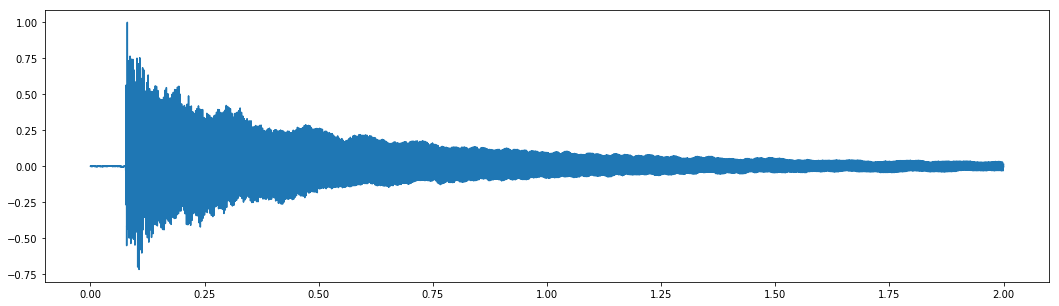

In [2]:
fs, y = gpitch.amtgp.wavread('../../../data/64_1-down.wav', start=10000, N=32000)
N = y.size
x = np.linspace(0, (N-1.)/fs, N).reshape(-1, 1)
plt.figure()
plt.plot(x, y)

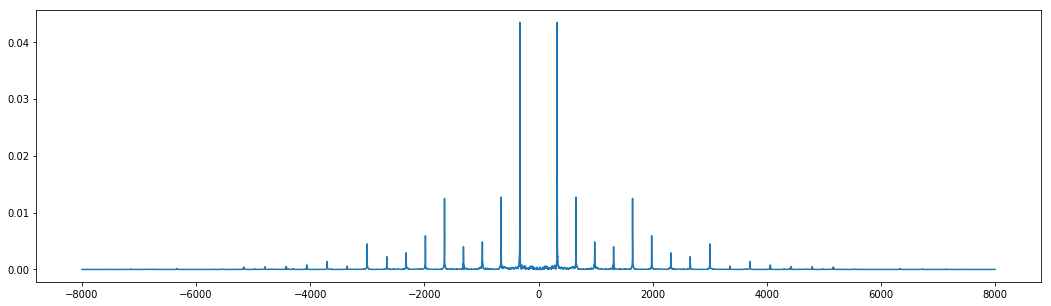

In [3]:
Y = fft(y.reshape(-1,))
S = 1./N*np.abs(fftshift(Y))
F = np.linspace(-0.5*fs, 0.5*fs, N)
plt.figure()
plt.plot(F, S)

/home/pa/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-0.01, 0.01)

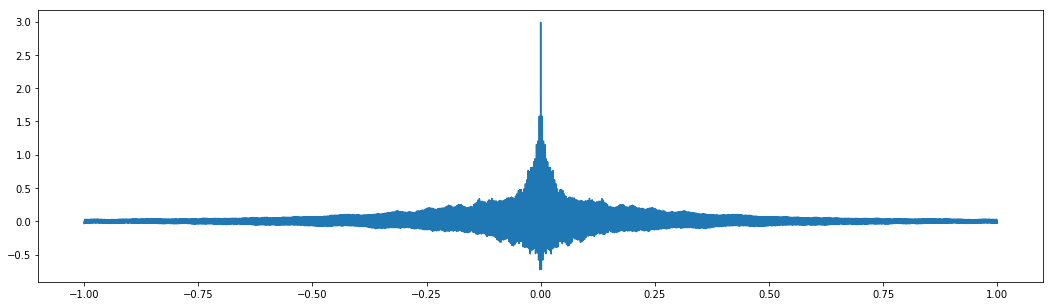

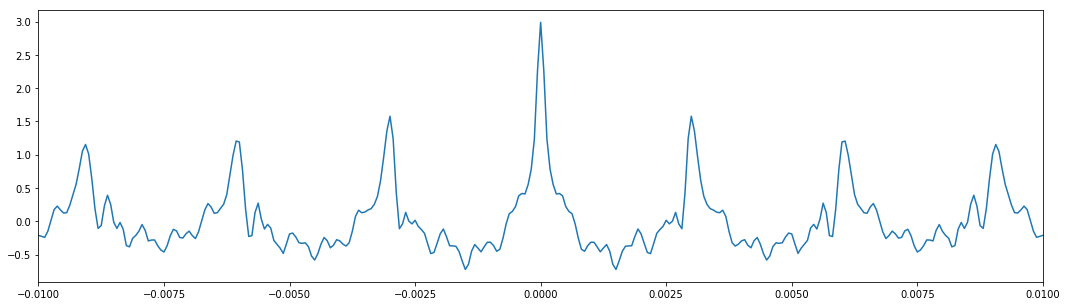

In [4]:
Yhat = np.abs(Y)
yhat = ifft(Yhat)
khat = ifftshift(yhat)


plt.figure()
plt.plot(x-1, khat)

plt.figure()
plt.plot(x-1, khat)
plt.xlim([-0.01, 0.01])

(-300, 300)

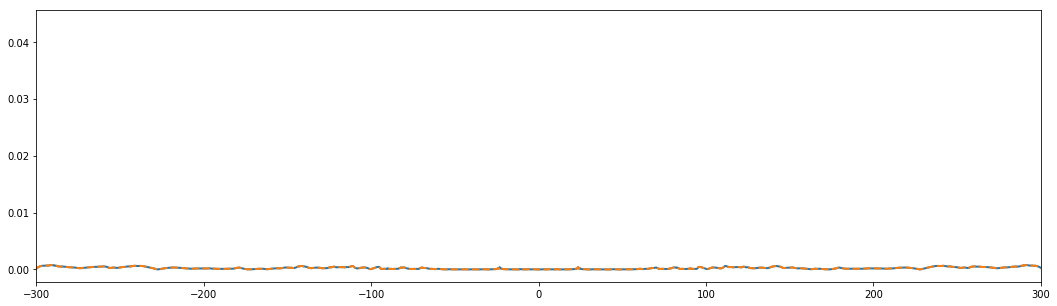

In [5]:
Sk = 1./N*fftshift(np.abs(fft(khat)))

plt.figure()
plt.plot(F, S, '-', lw=2)
plt.plot(F, Sk, '--', lw=2)
plt.xlim([-300, 300])

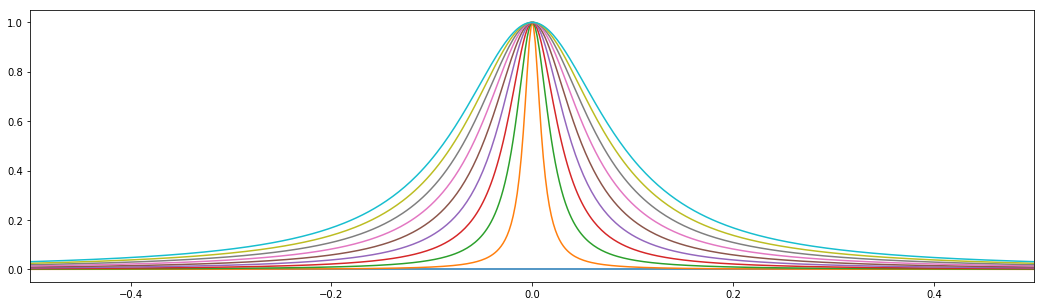

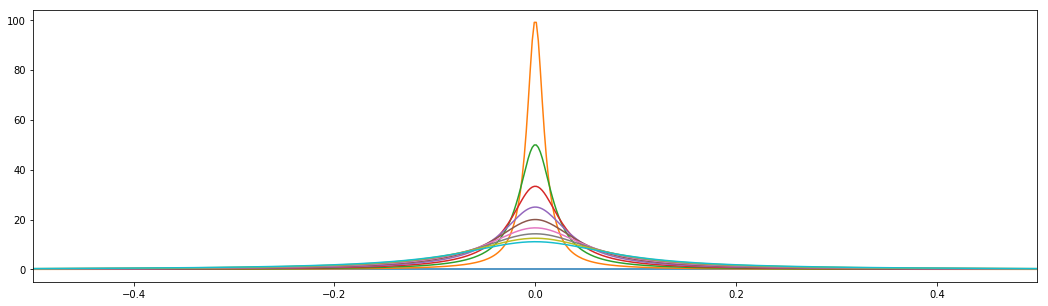

In [6]:
def func(x, a):
    return a**2. / ( a**2 + x**2)

def func2(x, a):
    return a / ( a**2 + x**2)

omega = np.linspace(-10, 10, 10000).reshape(-1,1)
plt.figure()
plt.xlim([-.5, .5])
for i in range(0, 10):
    plt.plot(omega, func(omega, 0.01*i))
    
plt.figure()
plt.xlim([-.5, .5])
for i in range(0, 10):
    plt.plot(omega, func2(omega, 0.01*i))

In [7]:
def k1(x, sig, leng, freq):
    return sig*leng**2. / ( leng**2 + (x - freq)**2)

def k2(x, sig, leng, freq):
    return sig*leng / ( leng**2 + (x - freq)**2)

0.000765162746132


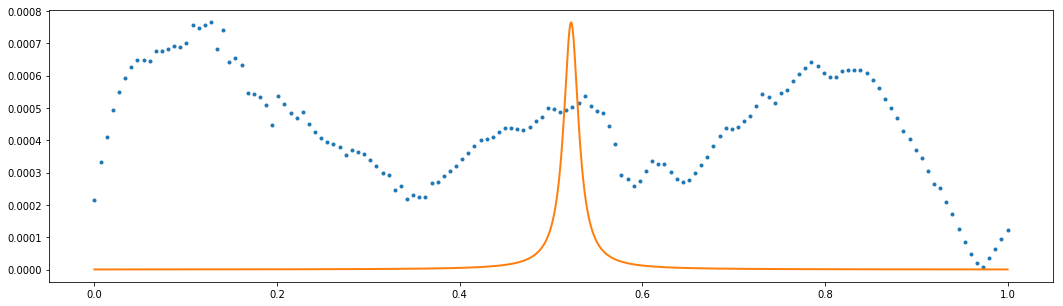

In [8]:
plt.figure()
data = S[15400: 15550].reshape(-1, 1)
xdata = np.linspace(0, 1, data.size).reshape(-1, 1)
plt.plot(xdata, data, '.', lw=2)


xoe = np.linspace(0, 1, 10000).reshape(-1, 1)
oe1 = k1(xoe, sig=data.max(), leng=0.01, freq=.522)
#oe2 = k2(xoe, sig=1.0, leng=0.1, freq=.522)

plt.plot(xoe, oe1, '-', lw=2)
#plt.plot(xoe, oe2, '-', lw=2)
print data.max()

# Compate analytical and numeric FFT of kernels

In [9]:
def kern(x, sig, lam, freq):
    return sig * np.exp(-lam*np.abs(x))* np.cos(freq*x)

def S_kern(omega, sig, lam, freq):
    a = lam / (lam**2 + (omega - freq)**2)
    b = lam / (lam**2 + (omega + freq)**2)
    return sig * ( a + b )

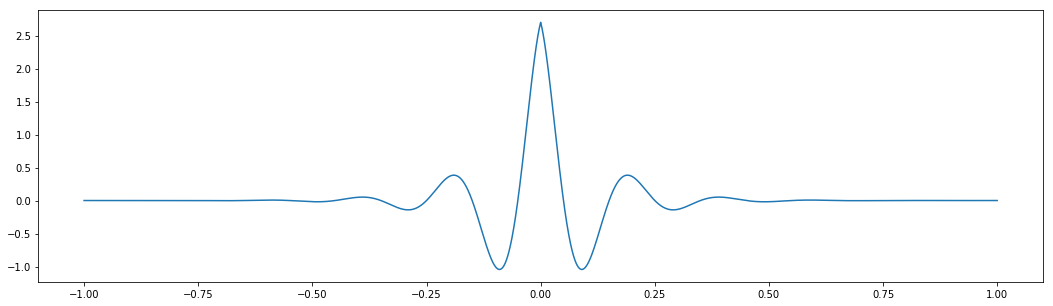

In [10]:
var = 2.7
lambda_param = 10.
freq = 2.*np.pi*5.
N = 32000
x = np.linspace(-1, 1, N).reshape(-1, 1)
kern_eval = kern(x, sig=var, lam=lambda_param, freq=freq)
plt.figure()
plt.plot(x, kern_eval)

(0, 100)

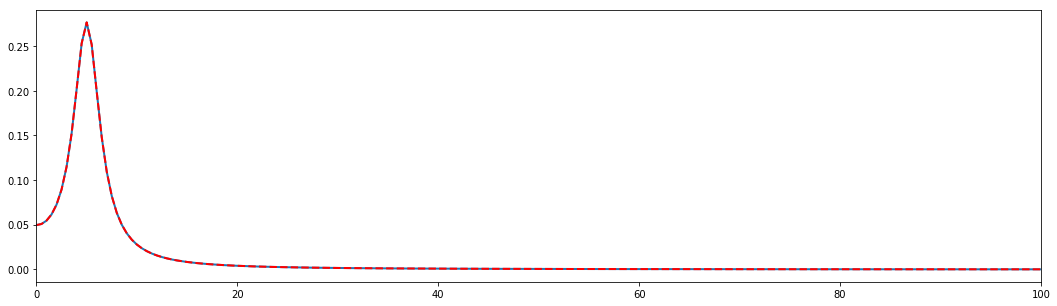

In [11]:
K = fft(kern_eval.reshape(-1,))
Sk = 2./N*np.abs(K[0:N/2])
F = np.linspace(0., 0.5*fs, N//2)
plt.figure()
plt.plot(F, Sk, lw=2)
plt.plot(F, S_kern(2*np.pi*F, sig=var, lam=lambda_param, freq=freq), '--r', lw=2)
plt.xlim([0, 100])

# Optimizing in  Time-distance domain

In [77]:
def piano_kernel(x, Nc, variances, lengthscales, F0, B):
    k = np.zeros((x.shape))
    for n in range(Nc):
        k += variances[n] * np.exp(-lengthscales[n]*np.abs(x)) * np.cos(2.*np.pi*n*F0*np.sqrt(1. + B*n**2)*x)
    return k

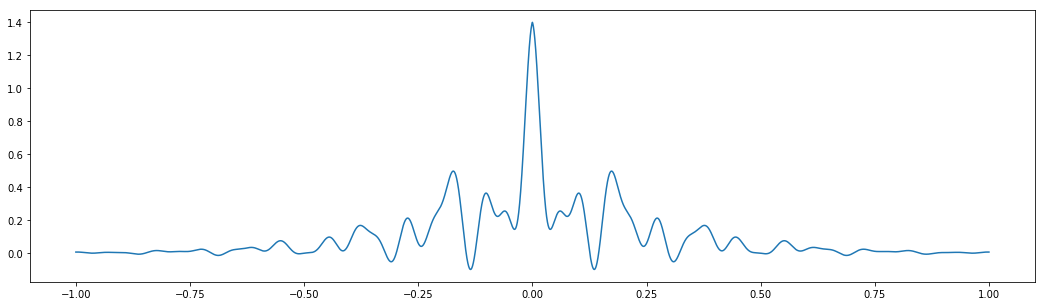

In [97]:
var = np.asarray([0.5, 0.3, 0.4, 0.2])
leng = np.asarray([5., 5., 5., 5.])
kernel = piano_kernel(x, Nc=4, variances=var, lengthscales=leng, F0=5., B=0.05)
plt.figure()
plt.plot(x, kernel)